In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import signal

In [3]:
import os
os.chdir('/home/jiarong/research/05.28/' + 'linear_m5B0Ustar0.51ak0.05Bo3.45Re31000.')

In [4]:
eta = pd.read_table('./eta0.3125', delimiter = ',')
field = pd.read_table('./field_direct0.3125', delimiter = ',')

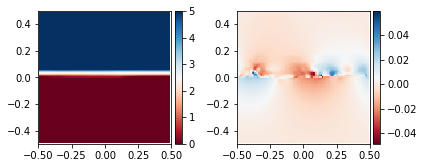

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
from scipy.interpolate import griddata
points = np.array([field.x, field.y])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_ux = griddata((field.x, field.y), field['u.x'], (grid_x, grid_y), method='cubic')
grid_uy = griddata((field.x, field.y), field['u.y'], (grid_x, grid_y), method='cubic')
fig, (ax1, ax2) = plt.subplots(ncols=2)
img1 = ax1.imshow(grid_ux.T, extent=(-0.5,0.5,-0.5,0.5), vmin=0, vmax=5, cmap='RdBu', origin='lower')
colorbar(img1)
img2 = ax2.imshow(grid_uy.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
colorbar(img2)
plt.tight_layout(h_pad=1)

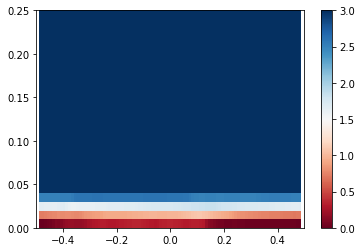

In [11]:
# Take a closer look by cut the domain into 4 parts
A, B, C, D = np.split(grid_ux.T, 4)
plt.imshow(C, extent=(-0.5,0.5,0,0.25), aspect = 'auto', vmin=0, vmax=3, cmap='RdBu', origin='lower')
plt.colorbar()

customerize colorbar
https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
fix colorbar height
https://joseph-long.com/writing/colorbars/
figsize: width, height in inches. If not provided, defaults to rcParams["figure.figsize"] = [6.4, 4.8].


/home/jiarong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jiarong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jiarong/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


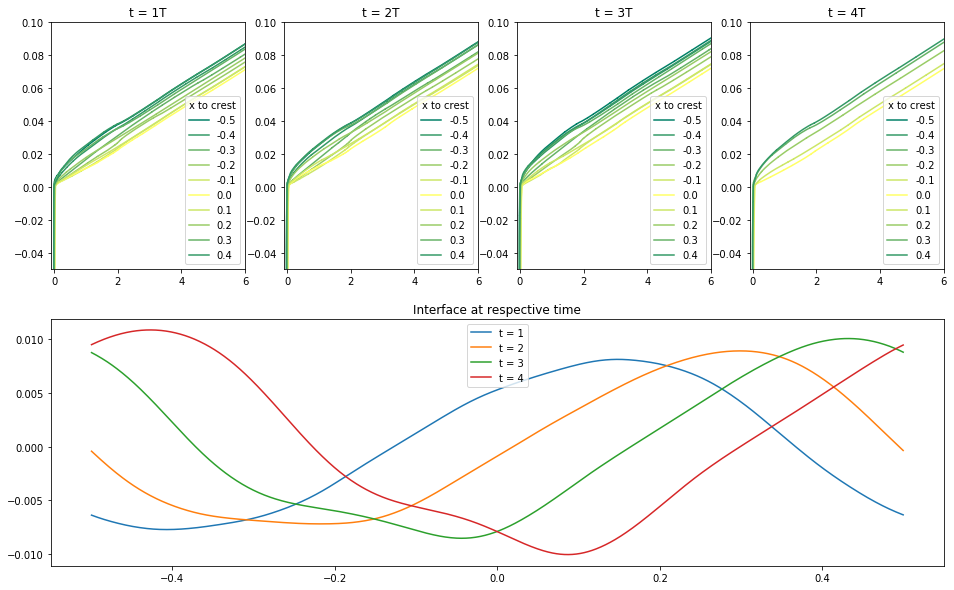

In [4]:
# Here at different time(choose interested ones from energy growth plot) 
# slice 10 x position(relative to the crest position) and change y coordinate relative to the elevation
# plot the velocity profile

import matplotlib.gridspec as gridspec
eps = 10**(-3) # eps is a value by trial
fig = plt.figure(figsize = [16, 10])
gs = gridspec.GridSpec(2, 4)
ax2 = fig.add_subplot(gs[1,:])

def plot_snapshot(number, t):
    ax = fig.add_subplot(gs[0, number-1])
    eta_sorted = eta.sort_values(by = ['x'])
    ax2.plot(eta_sorted.x, eta_sorted.pos, label = 't = %g' %t)
    # get the crest position
    crest = np.array(eta[eta['pos']==eta['pos'].max()].x)
    x_crest = np.average(crest)
    X = np.linspace(-0.5, 0.5, 10, endpoint=False)
    color_idx = np.linspace(1, 0, 6)
    for i,x in enumerate(X):
        if (x_crest+x) < 0.5:
            x_relative = x_crest + x 
        else:
            x_relative = x_crest + x - 1
        field_slice = field[np.abs(field.x - x_relative) < eps] 
        field_slice = field_slice.sort_values(by = ['y'])
        # get the interface elevation
        eta_slice = eta[np.abs(eta.x - x_relative) < eps]
        eta_x = np.average(eta_slice.pos)    
        ax.plot(field_slice['u.x'], field_slice.y - eta_x, label = '%1.1f' %x, 
                color=plt.cm.get_cmap('summer')(color_idx[abs(i-5)]))   
        ax.set_ylim([-0.05, 0.1])
        ax.set_xlim([-0.1, 6])
    ax.legend(title = 'x to crest', loc = 'lower right')
    ax.set_title('t = %gT' %t)
    
eta = pd.read_table('./eta1', delimiter = ',')
field = pd.read_table('./field_direct1', delimiter = ',')
plot_snapshot(1, 1)
eta = pd.read_table('./eta2', delimiter = ',')
field = pd.read_table('./field_direct2', delimiter = ',')
plot_snapshot(2, 2)
eta = pd.read_table('./eta3', delimiter = ',')
field = pd.read_table('./field_direct3', delimiter = ',')
plot_snapshot(3, 3)
eta = pd.read_table('./eta4', delimiter = ',')
field = pd.read_table('./field_direct4', delimiter = ',')
plot_snapshot(4, 4)
ax2.legend()
ax2.set_title('Interface at respective time')
fig.show()

In [21]:
# Compute the standard deviation as a function of time
fig = plt.figure(figsize = [12, 5])
N = 32*40; delta = 1; 
t = np.zeros(N)
ampl = np.zeros(N)
color_idx = np.linspace(0, 1, N//delta+1)
damage = 0
warning = ''
for i in range(32*39, N, delta):   
    # plot the elevation
    t[i] = i*1./32
    filename = "./eta%g" % t[i]
    exists = os.path.exists(filename)
    if not exists:
        warning += 't=%g ' % t[i]
        damage = 1
    if exists:
        eta = pd.read_table(filename, delimiter = ',')
        eta_sorted = eta.sort_values(by = ['x'])
        amplitude = np.array(eta.pos)
        # prevent an all zero array as it happens sometimes
        if np.any(amplitude):
            ampl[i] = np.std(amplitude)
            plt.plot(eta_sorted.x, eta_sorted.pos, label = 't = %g' %t[i], color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))
        # A mark line on crest position
#         crest = np.array(eta[eta['pos']==eta['pos'].max()].x)
#         x_crest = np.average(crest)
#         x = x_crest*np.ones(100)
#         y = np.linspace(0, 0.02, 100, endpoint=True)
#         plt.plot(x, y, color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))

<Figure size 864x360 with 0 Axes>

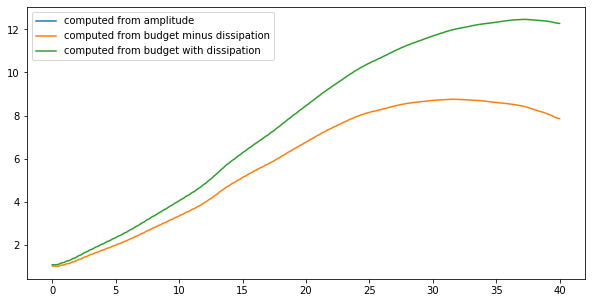

In [22]:
# filter out the zero ones
fig = plt.figure(figsize = [10, 5])
t_filter = np.array([])
ampl_filter = np.array([])
for i in range(0, N):
    if ampl[i] != 0:
        t_filter = np.append(t_filter, t[i])
        ampl_filter = np.append(ampl_filter, ampl[i]/ampl[0])
plt.plot(t_filter, ampl_filter**2, label = 'computed from amplitude')

from smooth_func import Smooth
energy = pd.read_table('./budgetWaterwind.dat', delimiter = ' ', error_bad_lines=False)
energy.drop(energy.tail(1).index,inplace=True)
diss = np.zeros(energy.shape[0])
total = energy.ke + energy.gpe
for i, row in energy.iterrows():
    if i == 0:
        diss[i] = 0
        last_t = row['t'] # record t in last row
    else:
        diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
        last_t = row['t']
# smooth the energy curve if needed for computing growth
total_diss = total + diss

total_hat = Smooth(np.array(total/total[0]),10001,'hanning')
total_diss_hat = Smooth(np.array((total+diss)/(total[0]+diss[0])),10001,'hanning')
plt.plot(energy.t, total_hat, label = 'computed from budget minus dissipation')
plt.plot(energy.t, total_diss_hat, label = 'computed from budget with dissipation')
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'eta'

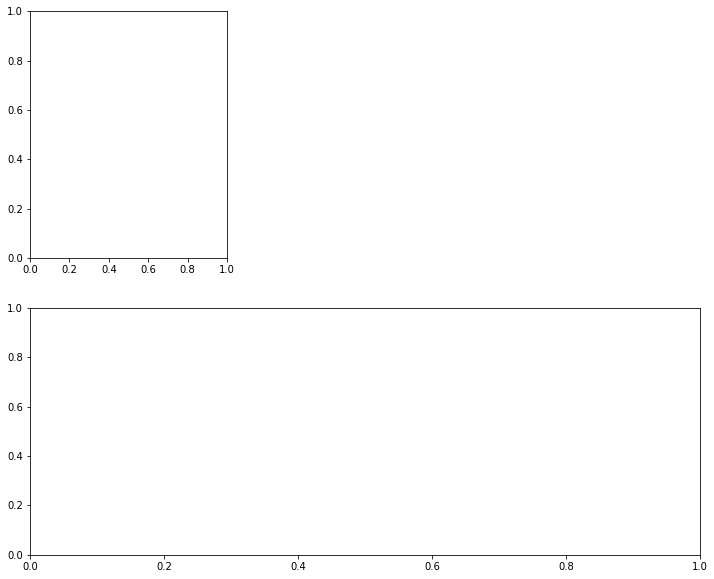

In [14]:
# This is the older script where eta is still called eta instead of  pos
# Here at different time(choose interested ones from energy growth plot) 
# slice 10 x position(relative to the crest position) and change y coordinate relative to the elevation
# plot the velocity profile

import matplotlib.gridspec as gridspec
eps = 10**(-3) # eps is a value by trial
fig = plt.figure(figsize = [12, 10])
gs = gridspec.GridSpec(2, 3)
ax2 = fig.add_subplot(gs[1,:])

def plot_snapshot(number, t):
    ax = fig.add_subplot(gs[0, number-1])
    eta_sorted = eta.sort_values(by = ['x'])
    ax2.plot(eta_sorted.x, eta_sorted.eta, label = 't = %g' %t)
    # get the crest position
    crest = np.array(eta[eta['eta']==eta['eta'].max()].x)
    x_crest = np.average(crest)
    X = np.linspace(-0.5, 0.5, 10, endpoint=False)
    color_idx = np.linspace(1, 0, 6)
    for i,x in enumerate(X):
        if (x_crest+x) < 0.5:
            x_relative = x_crest + x 
        else:
            x_relative = x_crest + x - 1
        field_slice = field[np.abs(field.x - x_relative) < eps] 
        field_slice = field_slice.sort_values(by = ['y'])
        # get the interface elevation
        eta_slice = eta[np.abs(eta.x - x_relative) < eps]
        eta_x = np.average(eta_slice.eta)    
        ax.plot(field_slice['u.x'], field_slice.y - eta_x, label = '%1.1f' %x, 
                color=plt.cm.get_cmap('summer')(color_idx[abs(i-5)]))   
        ax.set_ylim([-0.05, 0.1])
        ax.set_xlim([-0.1, 4])
    ax.legend(title = 'x to crest', loc = 'lower right')
    ax.set_title('t = %gT' %t)
    
eta = pd.read_table('./eta0.125', delimiter = ',')
field = pd.read_table('./field0.125', delimiter = ',')
plot_snapshot(1, 0.125)
eta = pd.read_table('./eta0.25', delimiter = ',')
field = pd.read_table('./field0.25', delimiter = ',')
plot_snapshot(2, 0.25)
eta = pd.read_table('./eta0.375', delimiter = ',')
field = pd.read_table('./field0.375', delimiter = ',')
plot_snapshot(3, 0.3125)
ax2.legend()
ax2.set_title('Interface at respective time')
fig.show()

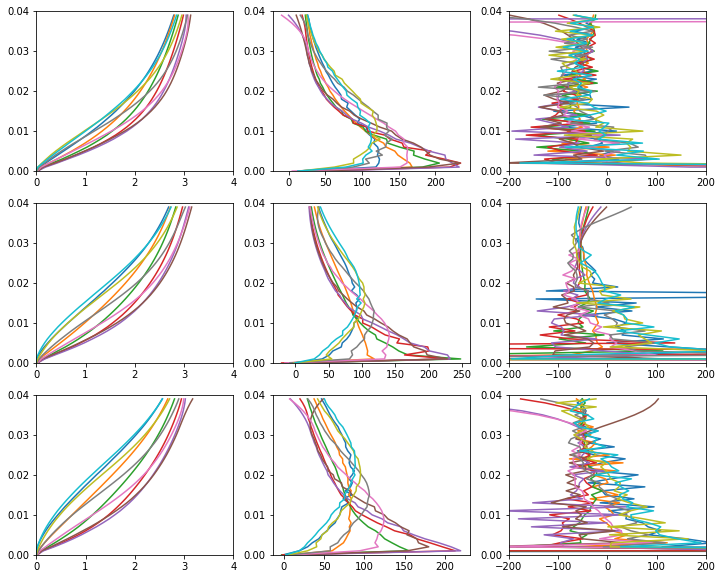

In [173]:
# scipy.interpolate.CubicSpline
from scipy.interpolate import CubicSpline

# number is simply the line of drawing
def critical_slice(number):
    # get the crest position
        # get the crest position
    x_crest = eta[eta['eta']==eta['eta'].max()].x.item()
    X = np.linspace(-0.5, 0.5, 10, endpoint=False)
    for i,x in enumerate(X[0:10]):
        # get the sliced field
        if (x_crest+x) < 0.5:
            x_relative = x_crest + x 
        else:
            x_relative = x_crest + x - 1
        field_slice = field[(np.abs(field.x - x_relative) < eps) & (field.y < 0.04)] 
        field_slice = field_slice.sort_values(by = ['y'])
        # get the interface elevation
        eta_slice = eta[np.abs(eta.x - x_relative) < eps]
        eta_x = np.average(eta_slice.eta) 
        # interpolate (with changed y)
        # At first got the warning: `x` must be strictly increasing sequence.
        # Need to drop duplicate
        field_slice = field_slice.drop_duplicates(subset=['y'])
        cs = CubicSpline(field_slice['y'] - eta_x, field_slice['u.x'])
        xs = np.arange(0, 0.04, 0.001)
        # 1D interpolation for the sliced field, force 2nd order derivative continuous
        ax1 = fig.add_subplot(gs[number,0])
        ax1.plot(cs(xs), xs, label="U")
#         ax1.plot(field_slice['u.x'], field_slice['y'] - eta_x, '.')
        ax2 = fig.add_subplot(gs[number,1])
        ax2.plot(cs(xs, 1), xs, label="U'")
        ax3 = fig.add_subplot(gs[number,2])
        ax3.plot(cs(xs, 2)/(cs(xs, 1)), xs, label="U''") 
        ax1.set_ylim([0, 0.04])
        ax1.set_xlim([0, 4])
        ax2.set_ylim([0, 0.04])
        ax3.set_ylim([0, 0.04])
        ax3.set_xlim([-200, 200])


fig = plt.figure(figsize = [12, 10])
gs = gridspec.GridSpec(3, 3)
eta = pd.read_table('./eta0.125', delimiter = ',')
field = pd.read_table('./field0.125', delimiter = ',')
critical_slice(0)
eta = pd.read_table('./eta0.25', delimiter = ',')
field = pd.read_table('./field0.25', delimiter = ',')
critical_slice(1)
eta = pd.read_table('./eta0.375', delimiter = ',')
field = pd.read_table('./field0.375', delimiter = ',')
critical_slice(2)

In [29]:
field = pd.read_table('./pressure0.125', delimiter = ' ')
x_crest = eta[eta['eta']==eta['eta'].max()].x.item()
X = np.linspace(-0.5, 0.5, 10, endpoint=False)
for i,x in enumerate(X[0:10]):
    # get the sliced field
    if (x_crest+x) < 0.5:
        x_relative = x_crest + x 
    else:
        x_relative = x_crest + x - 1
field.iloc[(field['x']-x_relative).abs().argsort()[:2]]
#     field_slice = field[np.abs(field.x - x_relative) < eps] 
#     field_slice = field_slice.sort_values(by = ['y'])
#     # get the interface elevation
#     eta_slice = eta[np.abs(eta.x - x_relative) < eps]
#     eta_x = np.average(eta_slice.eta) 
#     # interpolate (with changed y)
#     # At first got the warning: `x` must be strictly increasing sequence.
#     # Need to drop duplicate
#     field_slice = field_slice.drop_duplicates(subset=['y'])
#     cs = CubicSpline(field_slice['y'] - eta_x, field_slice['u.x'])
#     xs = np.arange(0, 0.1, 0.001)
#     # 1D interpolation for the sliced field, force 2nd order derivative continuous
#     ax1 = fig.add_subplot(gs[number,0])
#     ax1.plot(cs(xs), xs, label="U")
#     ax2 = fig.add_subplot(gs[number,1])
#     ax2.plot(cs(xs, 1), xs, label="U'")
#     ax3 = fig.add_subplot(gs[number,2])
#     ax3.plot(cs(xs, 2)/(cs(xs, 1)), xs, label="U''") 
#     ax1.set_ylim([0, 0.06])
#     ax1.set_xlim([0, 4])
#     ax2.set_ylim([0, 0.06])
#     ax3.set_ylim([0, 0.06])
#     ax3.set_xlim([-200, 200])

,x,y,u.x,p
4645,-0.21875,-0.492188,-0.001007,0.015457
4678,-0.21875,-0.234375,-0.002591,0.011554


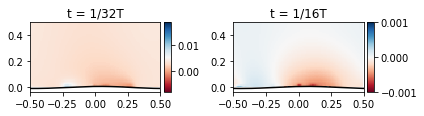

In [178]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
field = pd.read_table('./field_direct0.03125', delimiter = ',')
interface = pd.read_table('./eta0.03125', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
# colorbar(img1)
A, B = np.split(grid_p.T, 2)
# B = B - np.nanmean(B)
img1 = ax1.imshow(B, extent=(-0.5,0.5,0,0.5), cmap='RdBu', origin='lower')
colorbar(img1)
ax1.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax1.set_title('t = 1/32T')
field = pd.read_table('./field_direct0.0625', delimiter = ',')
interface = pd.read_table('./eta0.0625', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
A, B = np.split(grid_p.T, 2)
B = B - np.nanmean(B)
img2 = ax2.imshow(B, extent=(-0.5,0.5,0,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
colorbar(img2)
ax2.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax2.set_title('t = 1/16T')
plt.tight_layout(h_pad=1)

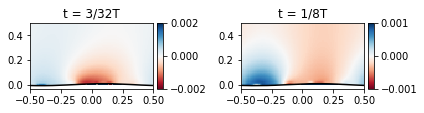

In [158]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
field = pd.read_table('./field_direct0.09375', delimiter = ',')
interface = pd.read_table('./eta0.09375', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
# colorbar(img1)
A, B = np.split(grid_p.T, 2)
B = B - np.nanmean(B)
img1 = ax1.imshow(B, extent=(-0.5,0.5,0,0.5), vmin=-0.002, vmax=0.002, cmap='RdBu', origin='lower')
colorbar(img1)
ax1.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax1.set_title('t = 3/32T')
field = pd.read_table('field_direct0.125', delimiter = ',')
interface = pd.read_table('./eta0.125', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
A, B = np.split(grid_p_aver.T, 2)
B = B - np.nanmean(B)
img2 = ax2.imshow(B, extent=(-0.5,0.5,0,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
colorbar(img2)
ax2.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax2.set_title('t = 1/8T')
plt.tight_layout(h_pad=1)

How to iterate over a dataframe:
https://medium.com/@rtjeannier/pandas-101-cont-9d061cb73bfc

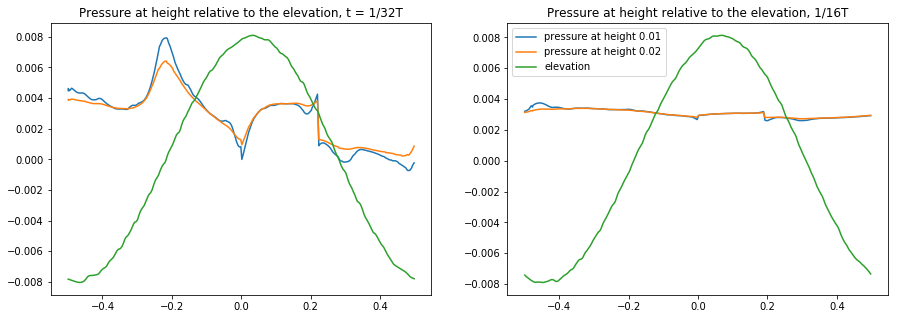

In [176]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

field = pd.read_table('./field_direct0.03125', delimiter = ',')
interface = pd.read_table('./eta0.03125', delimiter = ',')
lift = 0.01
interface = interface.iloc[::4, :]
eta_sorted = interface.sort_values(by = ['x'])
p = np.ones(interface.shape[0])
tau = np.zeros(interface.shape[0])
for index, row in interface.iterrows(): 
    # find the closest point to x and a certain lift up height(usually small)
    d = (field.y-row.eta-lift)**2 + (field.x-row.x)**2
    p[int(index/4)] = 0.5*(field.iloc[np.argsort(d)[0]]['p'] + field.iloc[np.argsort(d)[1]]['p'])
    tau[int(index/4)] = 0.5*(field.iloc[np.argsort(d)[0]]['tau.x'] + field.iloc[np.argsort(d)[1]]['tau.x'])   
# plt.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
ax1.plot(eta_sorted.x, p, label = 'pressure at height %g' % lift)
lift = 0.02
for index, row in interface.iterrows(): 
    # find the closest point to x and a certain lift up height(usually small)
    d = (field.y-row.eta-lift)**2 + (field.x-row.x)**2
    p[int(index/4)] = 0.5*(field.iloc[np.argsort(d)[0]]['p'] + field.iloc[np.argsort(d)[1]]['p'])
    tau[int(index/4)] = 0.5*(field.iloc[np.argsort(d)[0]]['tau.x'] + field.iloc[np.argsort(d)[1]]['tau.x'])   
ax1.plot(eta_sorted.x, p, label = 'pressure at height %g' % lift)
ax1.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
ax1.set_title('Pressure at height relative to the elevation, t = 1/32T')

# at another time
field = pd.read_table('./field_direct0.0625', delimiter = ',')
interface = pd.read_table('./eta0.0625', delimiter = ',')
lift = 0.01
interface = interface.iloc[::4, :]
eta_sorted = interface.sort_values(by = ['x'])
p = np.ones(interface.shape[0])
tau = np.zeros(interface.shape[0])
for index, row in interface.iterrows(): 
    # find the closest point to x and a certain lift up height(usually small)
    d = (field.y-row.eta-lift)**2 + (field.x-row.x)**2
    p[int(index/4)] = field.iloc[np.argsort(d)[0]]['p']
    tau[int(index/4)] = field.iloc[np.argsort(d)[0]]['tau.x'] 
# plt.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
ax2.plot(eta_sorted.x, p, label = 'pressure at height %g' % lift)
lift = 0.02
for index, row in interface.iterrows(): 
    # find the closest point to x and a certain lift up height(usually small)
    d = (field.y-row.eta-lift)**2 + (field.x-row.x)**2
    p[int(index/4)] = field.iloc[np.argsort(d)[0]]['p']
    tau[int(index/4)] = field.iloc[np.argsort(d)[0]]['tau.x']  
ax2.plot(eta_sorted.x, p, label = 'pressure at height %g' % lift)
ax2.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
ax2.set_title('Pressure at height relative to the elevation, 1/16T')

plt.legend()
plt.show()
# plt.plot(eta_sorted.x, tau, label = 'shear stress')
# plt.plot(eta_sorted.x, eta_sorted.p, label = 't = 0.125')
# slice = field[(field.y < 0.07) & (field.y > 0.06)]
# slice_sorted = slice.sort_values(by = ['x'])
# # plt.plot(eta_sorted.x, eta_sorted.p, label = 'pressure')
# # plt.plot(eta_sorted.x, eta_sorted['tau.x'], label = 'shear stress')
# plt.plot(slice_sorted.x, slice_sorted.p, label = 'pressure')
# plt.plot(slice_sorted.x, slice_sorted['tau.x'], label = 'shear stress')


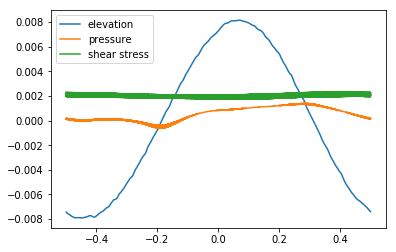

In [114]:
slice = field[(field.y < 0.07) & (field.y > 0.06)]
slice_sorted = slice.sort_values(by = ['x'])
# plt.plot(eta_sorted.x, eta_sorted.p, label = 'pressure')
# plt.plot(eta_sorted.x, eta_sorted['tau.x'], label = 'shear stress')
plt.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
plt.plot(slice_sorted.x, slice_sorted.p, label = 'pressure')
plt.plot(slice_sorted.x, slice_sorted['tau.x'], label = 'shear stress')
plt.legend()

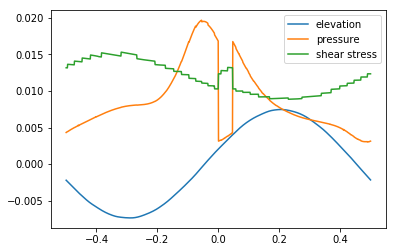

In [95]:
field = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/field0.1875', delimiter = ',')
interface = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/eta0.1875', delimiter = ',')
lift = 0.06
eta_sorted = interface.sort_values(by = ['x'])
p = np.zeros(interface.shape[0])
tau = np.zeros(interface.shape[0])
for index, row in interface.iterrows(): 
    d = (field.y-row.eta-lift)**2 + (field.x-row.x)**2
    p[index] = field.iloc[np.argsort(d)[0]]['p']
    tau[index] = field.iloc[np.argsort(d)[0]]['tau.x']    
plt.plot(eta_sorted.x, eta_sorted.eta, label = 'elevation')
plt.plot(eta_sorted.x, p, label = 'pressure')
plt.plot(eta_sorted.x, tau, label = 'shear stress')
# plt.plot(eta_sorted.x, eta_sorted.p, label = 't = 0.125')

# slice = field[(field.y < 0.07) & (field.y > 0.06)]
# slice_sorted = slice.sort_values(by = ['x'])
# # plt.plot(eta_sorted.x, eta_sorted.p, label = 'pressure')
# # plt.plot(eta_sorted.x, eta_sorted['tau.x'], label = 'shear stress')
# plt.plot(slice_sorted.x, slice_sorted.p, label = 'pressure')
# plt.plot(slice_sorted.x, slice_sorted['tau.x'], label = 'shear stress')
plt.legend()

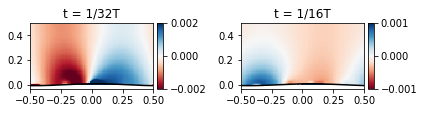

In [153]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
field = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/field_direct0.03125', delimiter = ',')
interface = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/eta0.03125', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
# img1 = ax1.imshow(grid_p.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
# colorbar(img1)
A, B = np.split(grid_p.T, 2)
B = B - np.nanmean(B)
img1 = ax1.imshow(B, extent=(-0.5,0.5,0,0.5), vmin=-0.002, vmax=0.002, cmap='RdBu', origin='lower')
colorbar(img1)
ax1.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax1.set_title('t = 1/32T')
field = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/field_direct0.0625', delimiter = ',')
interface = pd.read_table('../m5B0Ustar0.84ak0.05Bo3.45RE31000/eta0.0625', delimiter = ',')
eta_sorted = interface.sort_values(by = ['x'])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_p = griddata((field.x, field.y), field['p'], (grid_x, grid_y), method='cubic')
A, B = np.split(grid_p_aver.T, 2)
B = B - np.nanmean(B)
img2 = ax2.imshow(B, extent=(-0.5,0.5,0,0.5), vmin=-0.001, vmax=0.001, cmap='RdBu', origin='lower')
colorbar(img2)
ax2.plot(eta_sorted.x, eta_sorted.eta, color = 'black')
ax2.set_title('t = 1/16T')
plt.tight_layout(h_pad=1)

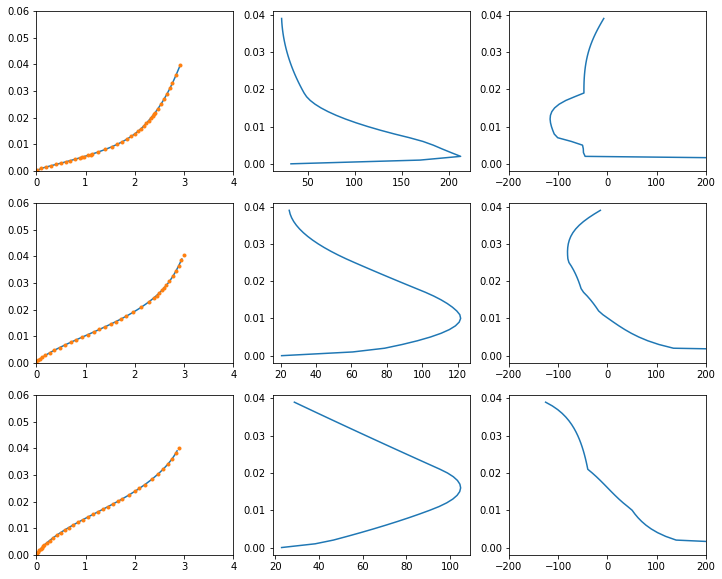

In [273]:
# scipy.interpolate.UnivariateSpline
from scipy.interpolate import UnivariateSpline

# number is simply the line of drawing
def critical_slice(number):
    # get the crest position
    x_crest = eta[eta['eta']==eta['eta'].max()].x.item()
    X = np.linspace(-0.5, 0.5, 10, endpoint=False)
    for i,x in enumerate(X[8:9]):
        # get the sliced field
        if (x_crest+x) < 0.5:
            x_relative = x_crest + x 
        else:
            x_relative = x_crest + x - 1
        field_slice = field[(np.abs(field.x - x_relative) < eps) & (field.y < 0.04)] 
        field_slice = field_slice.sort_values(by = ['y'])
        # get the interface elevation
        eta_slice = eta[np.abs(eta.x - x_relative) < eps]
        eta_x = np.average(eta_slice.eta) 
        # interpolate (with changed y)
        # At first got the warning: `x` must be strictly increasing sequence.
        # Need to drop duplicate
        field_slice = field_slice.drop_duplicates(subset=['y'])
        spl = UnivariateSpline(field_slice['y'] - eta_x, field_slice['u.x'], s = 1e-3)
        xs = np.arange(0, 0.04, 0.001)
        # 1D interpolation for the sliced field, force 2nd order derivative continuous
        ax1 = fig.add_subplot(gs[number,0])
        ax1.plot(spl(xs), xs, label="U")
        ax1.plot(field_slice['u.x'], field_slice['y'] - eta_x, '.')
        ax2 = fig.add_subplot(gs[number,1])
        ax2.plot(spl(xs, 1), xs, label="U'")
        ax3 = fig.add_subplot(gs[number,2])
        ax3.plot(spl(xs, 2)/(spl(xs, 1)), xs, label="U''") 
        ax1.set_ylim([0, 0.06])
        ax1.set_xlim([0, 4])
#         ax2.set_ylim([0, 0.06])
#         ax3.set_ylim([0, 0.06])
        ax3.set_xlim([-200, 200])
    ax.legend(title = 'x to crest', loc = 'lower right')

    
fig = plt.figure(figsize = [12, 10])
gs = gridspec.GridSpec(3, 3)
eta = pd.read_table('./eta0.03125', delimiter = ',')
field = pd.read_table('./field0.03125', delimiter = ',')
critical_slice(0)
eta = pd.read_table('./eta0.125', delimiter = ',')
field = pd.read_table('./field0.125', delimiter = ',')
critical_slice(1)
eta = pd.read_table('./eta0.25', delimiter = ',')
field = pd.read_table('./field0.25', delimiter = ',')
critical_slice(2)


In [49]:
## The functions used to analyze the energy growth. Now all global variables. Later should change to class attributes.
# Read in and calculate dissipation and growth rate
def energy_process(filename, smooth = 'NO'):
    energy = pd.read_table(filename, delimiter = ' ', error_bad_lines=False)
    cols = energy.columns
    for col in cols: # Parse into floating number
        energy[col] = energy[col].astype(float)
    diss = np.zeros(energy.shape[0])
    total = energy.ke + energy.gpe
    for i, row in energy.iterrows():
        if i == 0:
            diss[i] = 0
            last_t = row['t'] # record t in last row
        else:
            diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
            last_t = row['t']
    # smooth the energy curve if needed for computing growth
    if (smooth == 'YES'):
        # the energy is filtered and normalized
        b, a = signal.ellip(4, 0.01, 120, 0.001)  # Filter to be applied.
        total_hat = signal.filtfilt(b, a, total/total[0], method="gust")
        total_diss_hat = signal.filtfilt(b, a, (total+diss)/(total[0]+diss[0]), method="gust")
        growth_rate = np.gradient(total_hat, energy.t) / total_hat
        growth_rate_diss = np.gradient(total_diss_hat, energy.t) / total_diss_hat
    else:
        total_hat = np.ones(total.size)
        total_diss_hat = np.ones(total.size)
        growth_rate = np.gradient(total, energy.t) / total
        growth_rate_diss = np.gradient(total+diss, energy.t) / (total+diss)
    return [energy, total, diss, growth_rate, growth_rate_diss, total_hat, total_diss_hat]; 

# Plot the energy
# The default is only plot the total + dissipation energy and smoothing is not turned on
def energy_plot(ax, legend, simp = 'YES', smooth = 'NO'):   
    # The other lines' labels are suppressed
    ax.plot(energy.t, (diss+total)/(diss[0]+total[0]), label = legend)
    if smooth == 'YES':
        ax.plot(energy.t, total_diss_hat, label = 'smoothed')
    if simp != 'YES':
        ax.plot(energy.t, total/total[0], label = str())
        ax.plot(energy.t, energy.ke/energy.ke.iloc[0],  label = str())
        ax.plot(energy.t, energy.gpe/energy.gpe.iloc[0],  label = str())
    ax.set_xlabel('time')
    ax.set_ylabel('ke+gpe')
    ax.set_yscale('log')
    ax.set_yscale('log')

# Plot the growth rate (with filtering)
def energy_growthrate_plot(ax, legend):
    # plot the energy growth 
    # growth_rate_hat is the smoothed growth rate curve
#     growth_rate_hat = signal.savgol_filter(growth_rate, 100001, 3)
#     growth_rate_diss_hat = signal.savgol_filter(growth_rate_diss, 1001, 3)
    # plt.plot(energy.t[1000:], growth_rate[1000:])
    # plt.plot(energy.t[1000:], growth_rate_diss[1000:])
#     ax.plot(energy.t, growth_rate, label = str())
    ax.plot(energy.t, growth_rate_diss, label = legend)
    ax.set_xlabel('time')
    ax.set_ylabel('growth rate')

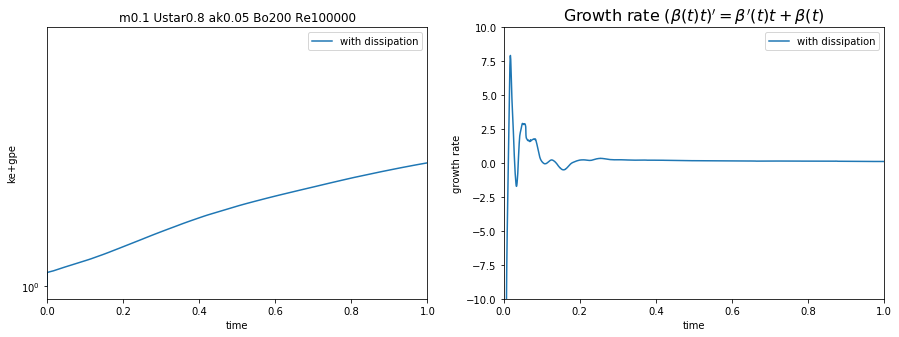

In [64]:
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Read in different energy data
filename = './budgetWaterwind.dat'
label = 'with dissipation'  # The legend has to be specified when plotting the figure
[energy, total, diss, growth_rate, growth_rate_diss, total_hat, total_diss_hat] = energy_process(filename, smooth = 'YES')
energy_plot(ax1, label, simp = 'YES', smooth = 'NO') # simp = 'YES' for simplified plots
energy_growthrate_plot(ax2, label)
# filename = './test_level9/budgetWaterwind.dat'
# label = 'pressure gradient on level 9'  # The legend has to be specified when plotting the figure
# [energy, total, diss, growth_rate, growth_rate_diss] = energy_process(filename)
# energy_plot(ax1, label, simp = 'YES') # simp = 'YES' for simplified plots
# energy_growthrate_plot(ax2, label)
# filename = '../03.25/m0.1B0Ustar1ak0.05Bo200Re100000./budgetWaterwind.dat'
# label = 'pressure gradient off'  # The legend has to be specified when plotting the figure
# [energy, total, diss, growth_rate, growth_rate_diss] = energy_process(filename)
# energy_plot(ax1, label, simp = 'YES') # simp = 'YES' for simplified plots
# energy_growthrate_plot(ax2, label)
ax1.legend()
ax2.legend()
ax1.set_title('m0.1 Ustar0.8 ak0.05 Bo200 Re100000')
ax2.set_title('Growth rate ' + r"$(\beta(t)t)' = \beta'(t)t + \beta(t) $", fontsize=16)
ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([-10, 10])
fig.show()
